# Tensorflow classificator
In this notebook I will implement a simple supervised classificator using tensorflow
## Loading the data
First I'll load the data and will separate it for classification

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
#loading the data
# This dataset was generated in the 4.0-comparison-supervised-algorithms.ipynb notebook
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


I need to get the data ready for classification:

In [3]:
from sklearn.preprocessing import MinMaxScaler
from benchtools.src.datatools import separate_data
from sklearn.model_selection import train_test_split

# Separating characteristics from label
X, y = separate_data(df, standarize=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminating the columns of mass so that the training is model-free 
X_train_nm = X_train.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test_nm = X_test.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

# Standarizing the variables
scaler = MinMaxScaler()
X_train_nm[X_train_nm.columns] = scaler.fit_transform(X_train_nm[X_train_nm.columns])
X_test_nm[X_test_nm.columns] = scaler.fit_transform(X_test_nm[X_test_nm.columns])


X_train_nm.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons
269950,0.023766,0.447932,0.572749,0.026637,0.194259,0.177165,0.236204,0.319188,0.073249,0.228341,0.187415,0.170732,0.468489,0.135043
501714,0.163466,0.512338,0.824834,0.110933,0.288922,0.240157,0.329691,0.687570,0.317613,0.344764,0.245672,0.178862,0.495242,0.184615
381639,0.073016,0.411868,0.253741,0.062484,0.412827,0.244094,0.282658,0.334711,0.745132,0.259233,0.184162,0.321138,0.446029,0.249573
449407,0.014362,0.379798,0.973110,0.043124,0.493650,0.244094,0.242288,0.251246,0.438868,0.310071,0.313793,0.272358,0.524856,0.244444
175477,0.066394,0.255427,0.177565,0.216971,0.459898,0.074803,0.166781,0.368110,0.719979,0.130329,0.703020,0.186992,0.533256,0.150427


## Model
Here I'll create the model and train it. First I'm going to state the construction of the model

In [4]:
# How many characteristics we are using
input_shape = [X_train_nm.shape[1]]

# Creating the model
# Here are the layers with batch normalization, the drop out rate and the activations
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

We also need a loss function

In [5]:
# Choosing the optimizer
# Binary crossentropy for binary classification
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],)

# We use early stop to prevent the model from overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

## Training
Now, I'll train the model

In [6]:
history = model.fit(
    X_train_nm, y_train,
    validation_data=(X_test_nm, y_test),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
700/700 [==============================] - 78s 108ms/step - loss: 0.1931 - binary_accuracy: 0.9325 - val_loss: 0.1212 - val_binary_accuracy: 0.9555
Epoch 2/200
700/700 [==============================] - 81s 116ms/step - loss: 0.1270 - binary_accuracy: 0.9530 - val_loss: 0.1164 - val_binary_accuracy: 0.9564
Epoch 3/200
700/700 [==============================] - 68s 98ms/step - loss: 0.1213 - binary_accuracy: 0.9551 - val_loss: 0.1170 - val_binary_accuracy: 0.9564
Epoch 4/200
700/700 [==============================] - 68s 97ms/step - loss: 0.1183 - binary_accuracy: 0.9563 - val_loss: 0.1143 - val_binary_accuracy: 0.9575
Epoch 5/200
700/700 [==============================] - 61s 87ms/step - loss: 0.1167 - binary_accuracy: 0.9568 - val_loss: 0.1127 - val_binary_accuracy: 0.9583
Epoch 6/200
700/700 [==============================] - 61s 87ms/step - loss: 0.1153 - binary_accuracy: 0.9571 - val_loss: 0.1144 - val_binary_accuracy: 0.9581
Epoch 7/200
700/700 [=======================

## Classification
Once the model is trained, I can use it to predict the probability of each event being signal or background

In [7]:
y_prob = model.predict(X_test_nm)
my_list = map(lambda x: x[0], y_prob)
y_pred = pd.Series(my_list)

y_pred.head()

0    0.025436
1    0.002415
2    0.002673
3    0.000416
4    0.000356
dtype: float32

We want to convert this probability to 0 or 1, to be able to calculate metrics about the performance of the classificator

In [8]:
# Adding the series to the dataframe with the masses
X_test = X_test.assign(y_test=pd.Series(y_test).values)
X_test = X_test.assign(y_pred=pd.Series(y_pred).values)
# Here I choose 0.5 as the threshole but that can be changed
# and can affect the metrics
X_test['y_pred']=(X_test['y_pred'] >= .5).astype(float)

X_test.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,y_test,y_pred
58904,1245.335366,589.122521,-0.591652,2.566940,1583.408925,0.252553,100,1113.805169,61.245864,0.801365,-0.797360,1492.250629,0.301229,31,3054.421585,3.641292,191.0,0.0,0.0
474643,1490.167755,123.532076,0.163960,0.372214,1515.286474,0.709907,39,1419.495073,60.903034,0.001545,-2.751416,1420.802678,0.440108,27,2924.658648,3.127850,109.0,0.0,0.0
505755,1436.961210,101.657847,-0.488022,0.427252,1614.704990,0.620576,31,1061.226122,282.394158,0.430838,-2.555102,1195.095384,0.343264,88,2765.624632,3.120696,195.0,0.0,0.0
467650,1261.358720,218.808374,1.172695,1.354259,2243.439433,0.726776,51,1201.313206,287.944492,-1.255317,-1.732465,2296.971844,0.347862,112,4538.534805,3.927227,234.0,0.0,0.0
453815,1300.249334,232.676144,0.123892,2.329810,1330.740280,0.933545,64,1224.618066,150.389562,-0.065651,-0.714245,1236.438223,0.409710,42,2561.831397,3.049950,183.0,0.0,0.0


## Performance
Some variables like precision or the f1 score will tell us about how good the classificator did. First I'm going to get a general report

In [9]:
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score

print(classification_report(X_test['y_test'], X_test['y_pred'], target_names=['background','signal']))

              precision    recall  f1-score   support

  background       0.97      0.99      0.98    139578
      signal       0.85      0.67      0.75     14022

    accuracy                           0.96    153600
   macro avg       0.91      0.83      0.86    153600
weighted avg       0.96      0.96      0.96    153600



And some specific variables I'm interested in:

In [10]:
precision = precision_score(y_test, X_test['y_pred'])
ll = log_loss(y_test, y_prob)
f1 = f1_score(y_test, X_test['y_pred'])
recall = recall_score(y_test, X_test['y_pred'])

print('recall: {0:.2}, precision: {0:.2%}, log loss: {0:.2f}, f1 score:{0:.2f}'.format(recall, precision*100, ll, f1))

recall: 0.67, precision: 66.70%, log loss: 0.67, f1 score:0.67


Here I will plot some ROC curves and obtain the AUC using benchtools

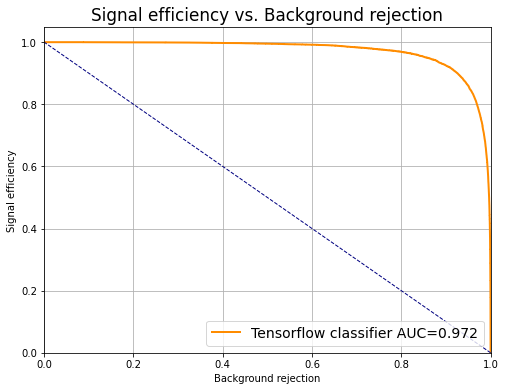

In [11]:
from benchtools.src.metrictools import sig_eff_bkg_rej

sig_eff_bkg_rej(names=['Tensorflow classifier'], label=y_test, probs=[y_prob], colors=['darkorange'])
plt.show()

C:\Users\maria\anaconda3\lib\site-packages\benchtools\src\metrictools.py:197: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color=color, lw=2,


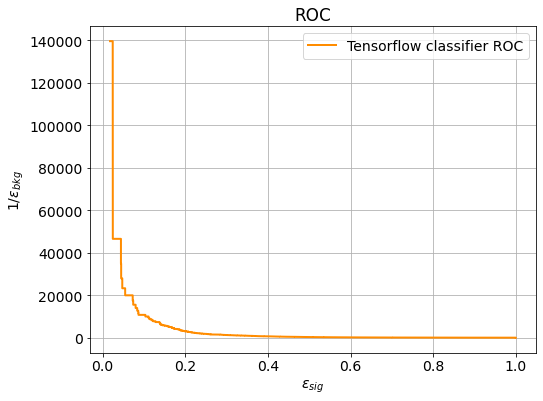

In [12]:
from benchtools.src.metrictools import sig_eff_inv_bkg_eff

sig_eff_inv_bkg_eff(names=['Tensorflow classifier'], label=y_test, probs=[y_prob], colors=['darkorange'])
plt.show()

We can also plot the precision-recall curve

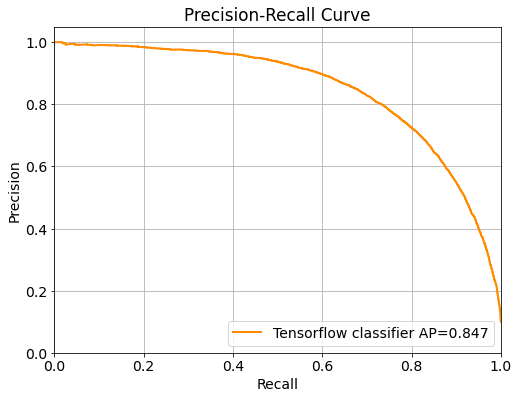

In [13]:
from benchtools.src.metrictools import precision_recall_plot

precision_recall_plot(names=['Tensorflow classifier'], label=y_test, probs=[y_prob], colors=['darkorange'])
plt.show()

## The prediction
Here we can take a look of how the prediction looks vs. how the real data is distributed

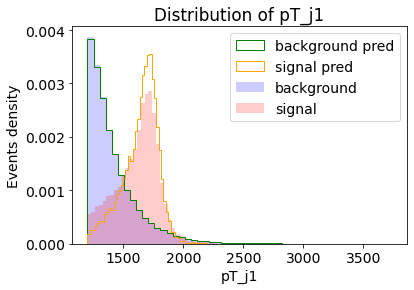

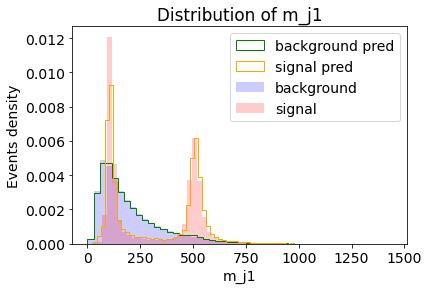

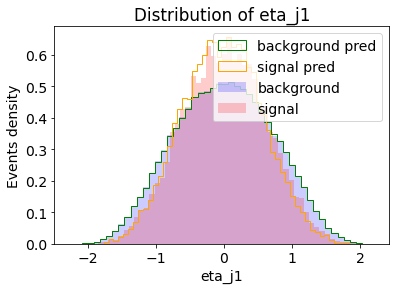

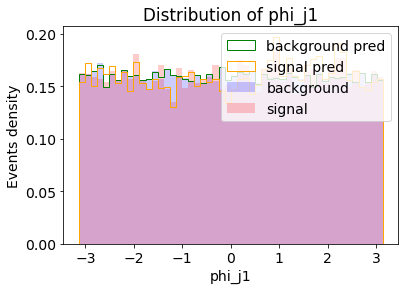

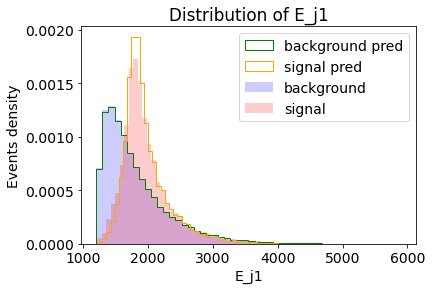

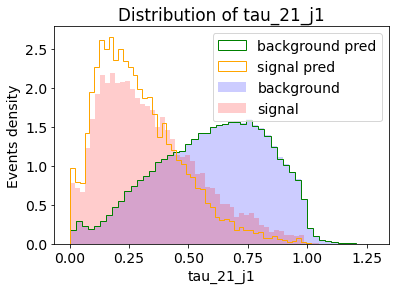

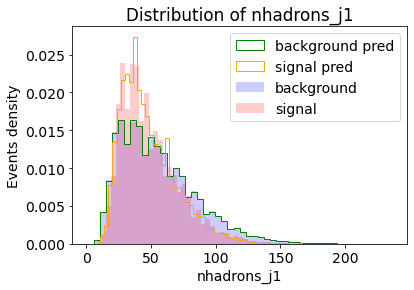

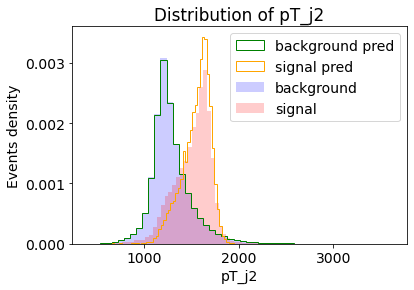

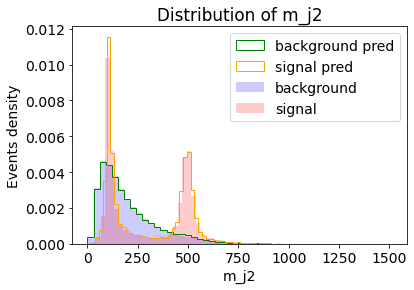

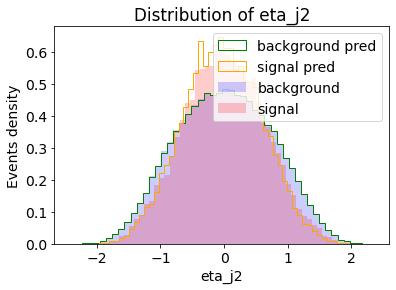

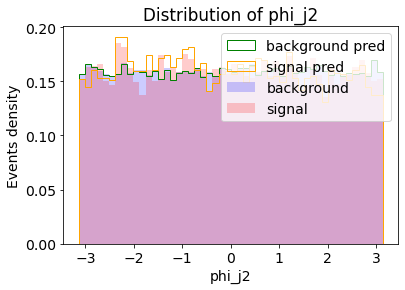

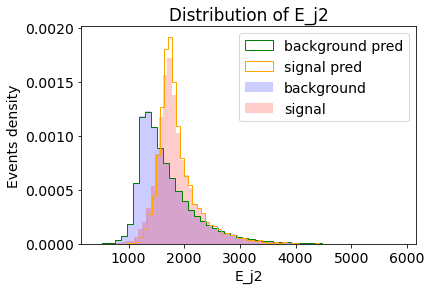

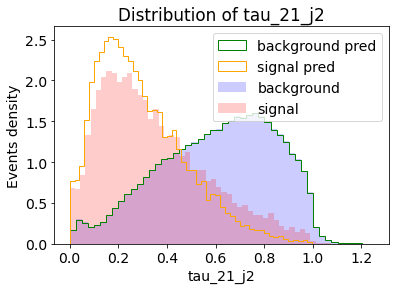

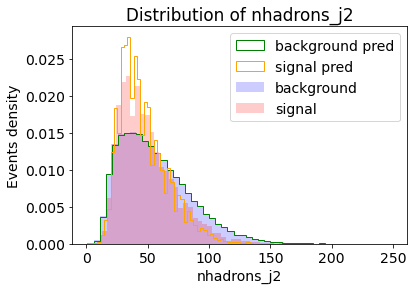

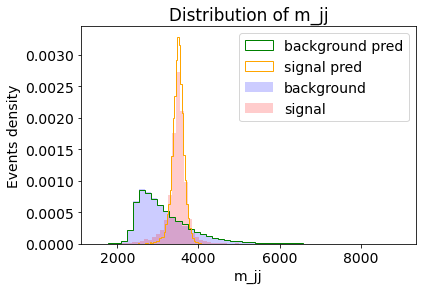

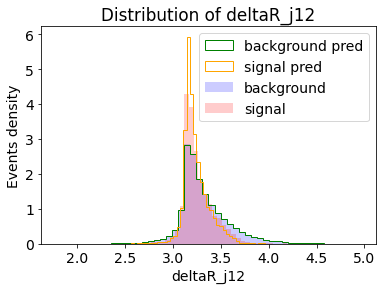

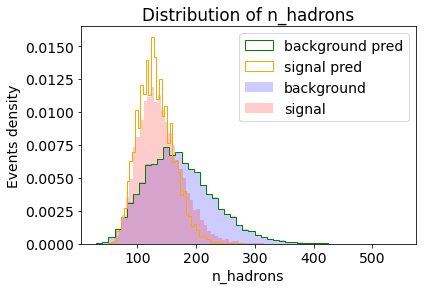

In [14]:
from benchtools.src.plotools import pred_test_hist
variables=X_test.drop(['y_pred','y_test'], axis=1).columns.tolist()

for variable in variables:
    pred_test_hist(X_test, variable, ypred='y_pred', ytest='y_test', n_bins=50, log=False)

## BB1 dataset
I'm going to calculate the performance variables for the predictions on the BB1 dataset with the model trained above. Then the plots of how the data is distributed according to the prediction vs. the real distributions.

In [16]:
# Loading the data
df_bb = pd.read_csv("..\data\BB1_dataset.csv")
df_bb.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0


In [17]:
# Preparing the data for classification
X, y = separate_data(df_bb, standarize=False)
# Eliminating masses for the model free classification
X_cl = X.drop(['m_j1','m_j2','m_jj'], axis=1)
# Standarizing the variables
scaler = MinMaxScaler()
X_cl[X_cl.columns] = scaler.fit_transform(X_cl[X_cl.columns])

In [18]:
# Predicting the probability
y_prob = model.predict(X_cl)
my_list = map(lambda x: x[0], y_prob)
y_pred = pd.Series(my_list)

y_pred.head()

0    0.000462
1    0.000583
2    0.055507
3    0.001026
4    0.052873
dtype: float32

In [19]:
# Adding the prediction and labels to the main dataframe
X = X.assign(y_test=pd.Series(y).values)
X = X.assign(y_pred=pd.Series(y_pred).values)
X['y_pred']=(X['y_pred'] >= .5).astype(float)

X.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,y_test,y_pred
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0,0.0


In [20]:
# Calculating the principal metrics
precision = precision_score(y, X['y_pred'])
ll = log_loss(y, y_prob)
f1 = f1_score(y, X['y_pred'])
recall = recall_score(y, X['y_pred'])

print('recall: {0:.2}, precision: {0:.2%}, log loss: {0:.2f}, f1 score:{0:.2f}'.format(recall, precision*100, ll, f1))

recall: 0.56, precision: 56.09%, log loss: 0.56, f1 score:0.56


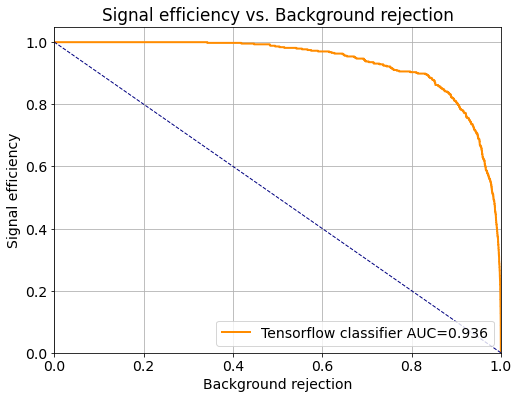

In [21]:
# ROC and AUC
sig_eff_bkg_rej(names=['Tensorflow classifier'], label=y, probs=[y_prob], colors=['darkorange'])
plt.show()

C:\Users\maria\anaconda3\lib\site-packages\benchtools\src\metrictools.py:197: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color=color, lw=2,


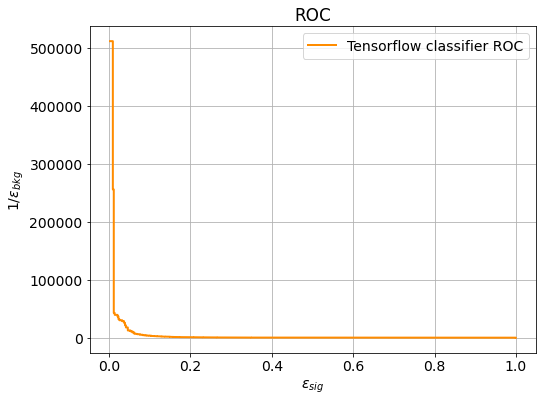

In [22]:
sig_eff_inv_bkg_eff(names=['Tensorflow classifier'], label=y, probs=[y_prob], colors=['darkorange'])
plt.show()

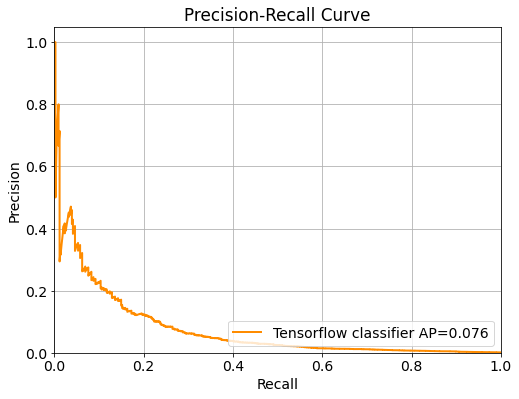

In [23]:
precision_recall_plot(names=['Tensorflow classifier'], label=y, probs=[y_prob], colors=['darkorange'])
plt.show()

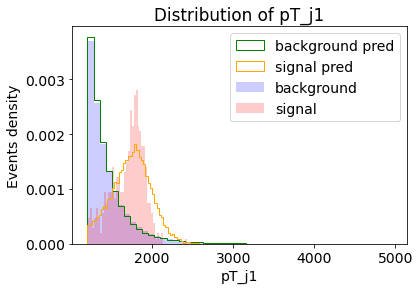

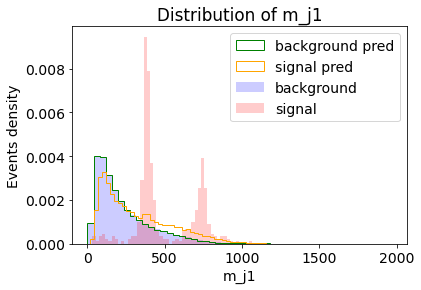

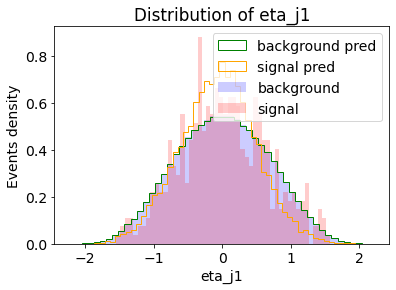

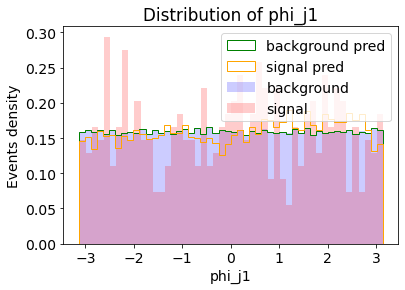

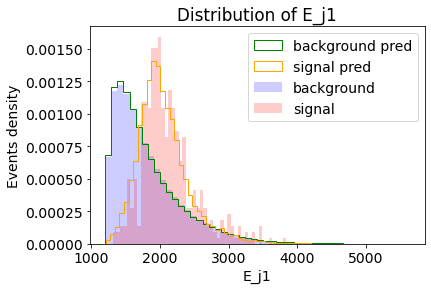

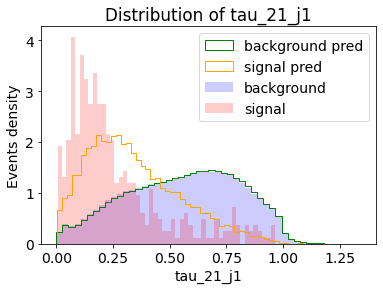

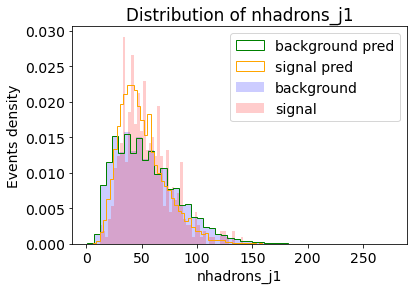

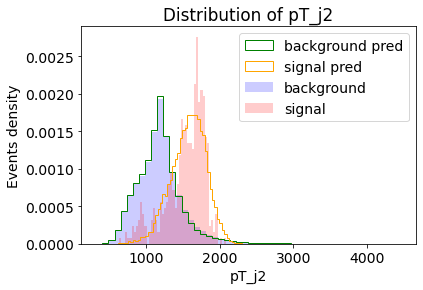

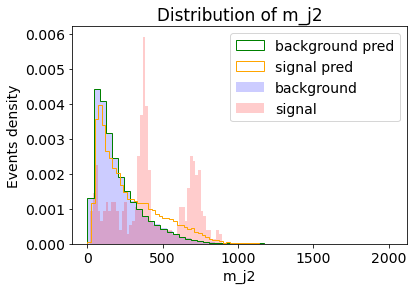

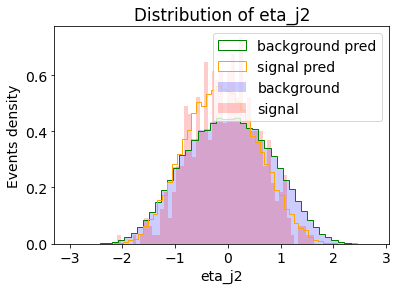

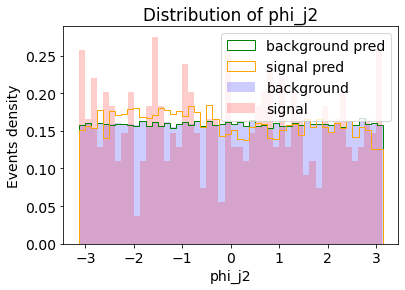

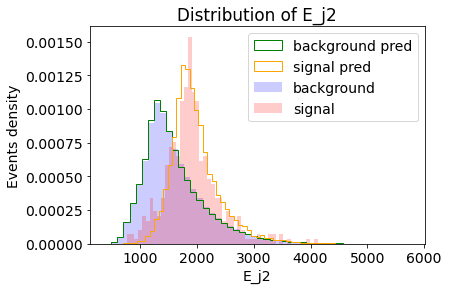

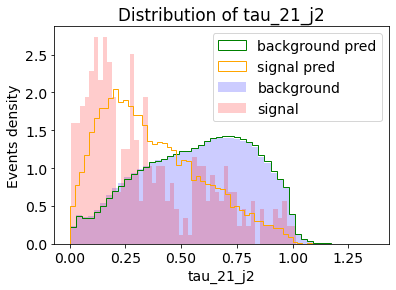

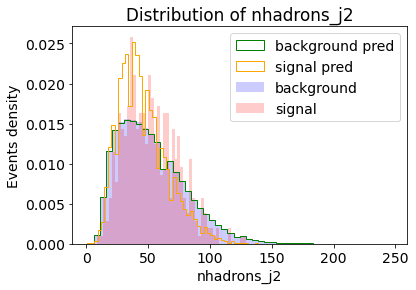

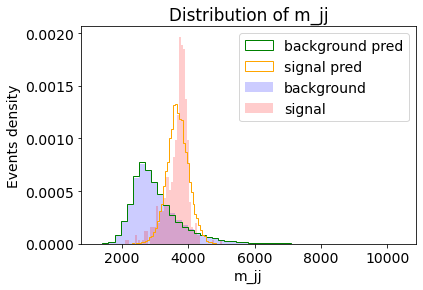

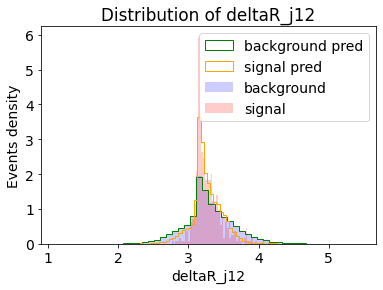

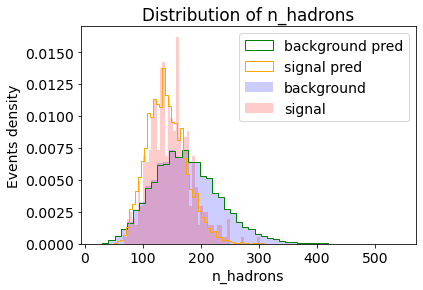

In [24]:
# The distributions
for variable in variables:
    pred_test_hist(X, variable, ypred='y_pred', ytest='y_test', n_bins=50, log=False)